# <a id='toc1_'></a>[Visualize Classifier Performance](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Visualize Classifier Performance](#toc1_)    
  - [Parse the wandb results](#toc1_1_)    
  - [Create a dataframe with the results](#toc1_2_)    
  - [Visualize the results](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os
import pandas as pd
import seaborn as sns

In [2]:
wandb_results_dir = 'results/wandb'
output_dir = 'results'

In [3]:
# list all files in results directory
files = os.listdir(wandb_results_dir)
files = [f for f in files if f.endswith(".csv")]
type = ("imagenette", "woof", "stfdogs")

## <a id='toc1_1_'></a>[Parse the wandb results](#toc0_)

In [4]:
dfs = dict()
for t in type:
    fs = [f for f in files if t in f]
    df = pd.concat([pd.read_csv(f'{wandb_results_dir}/' + f) for f in fs], axis=1)
    # drop columns if contain __MIN, __MAX, _step
    df = df.drop([c for c in df.columns if '__MIN' in c], axis=1)
    df = df.drop([c for c in df.columns if "__MAX" in c], axis=1)
    df = df.drop([c for c in df.columns if "_step" in c], axis=1)
    # rename columns by replacing model names
    mapping = {"mbn2-mix-200-clean": "mbn2-mix-clean-200", "mix-300-ft": "mix-ft-300"}
    for k, v in mapping.items():
        df.columns = df.columns.str.replace(k, v)
    # remove duplicate columns
    df = df.loc[:, ~df.columns.duplicated()].copy()
    models = set()
    params = set()
    itercols = []
    for i in df.columns:
        if " - " in i:
            model = i.split(" - ")[0]
            param = i.split(" - ")[1]
            models.add(model)
            params.add(param)
            itercols.append(i)
    pivot_dict = {
        "type": [],
        "model": [],
        "epoch": [],
    }
    for p in params:
        pivot_dict[p.replace('epoch/','')] = []
    for i, row in df.iterrows():
        ep = row["epoch/epoch"]
        for m in models:
            pivot_dict["type"].append(t)
            pivot_dict["model"].append(m)
            pivot_dict["epoch"].append(ep)
            for p in params:
                param = p.replace('epoch/','')
                pivot_dict[param].append(row[m + " - " + p])
    pivot_df = pd.DataFrame(pivot_dict)
    dfs[t] = pivot_df

## <a id='toc1_2_'></a>[Create a dataframe with the results](#toc0_)

In [5]:
# merge all dataframes
df = pd.concat(dfs.values()).dropna()
df["epoch"] = df["epoch"].astype(int)
df.head()

,type,model,epoch,train_learning_rate,test_loss,test_acc1,test_acc5
0,imagenette,synthetic-200,0,0.1,3.393866,19.821656,69.350318
1,imagenette,mix-200,0,0.1,2.713810,18.038217,70.573248
4,imagenette,mbn2-base-200,0,0.1,3.026178,24.203822,66.598726
6,imagenette,mbn2-synthetic-200,0,0.1,2.445955,32.178344,82.471338
7,imagenette,mbn2-mix-200,0,0.1,1.799331,41.987261,87.133758


In [6]:
df.to_csv(f"{output_dir}/table/merged_results.csv", index=False)

## <a id='toc1_3_'></a>[Visualize the results](#toc0_)

In [7]:
df_plot = df.copy()
# rename all models with 300 to 200
df_plot["model"] = df_plot["model"].str.replace("300", "200")
df_plot["model"] = df_plot["model"].str.replace("-ft", "")
df_plot["model"] = df_plot["model"].str.replace("-200", "")

In [8]:
mapping = {
    "base": "ResNet18_Original",
    "mix": "ResNet18_Original+Synthetic(Noisy)",
    "mix-clean": "ResNet18_Original+Synthetic(Clean)",
    "synthetic": "ResNet18_Synthetic",
    "mbn2-base": "MobileNetV2_Original",
    "mbn2-mix": "MobileNetV2_Original+Synthetic(Noisy)",
    "mbn2-mix-clean": "MobileNetV2_Original+Synthetic(Clean)",
    "mbn2-synthetic": "MobileNetV2_Synthetic",
}
df_plot["model"] = df_plot["model"].replace(mapping)

ds_mapping = {
    "imagenette": "Imagenette",
    "woof": "Imagewoof",
    "stfdogs": "Stanford Dogs",
}
df_plot["type"] = df_plot["type"].replace(ds_mapping)

In [9]:
df_plot['data'] = df_plot['model'].str.split('_').str[1]
df_plot["model"] = df_plot["model"].str.split("_").str[0]
df_plot.head(2)

,type,model,epoch,train_learning_rate,test_loss,test_acc1,test_acc5,data
0,Imagenette,ResNet18,0,0.1,3.393866,19.821656,69.350318,Synthetic
1,Imagenette,ResNet18,0,0.1,2.713810,18.038217,70.573248,Original+Synthetic(Noisy)


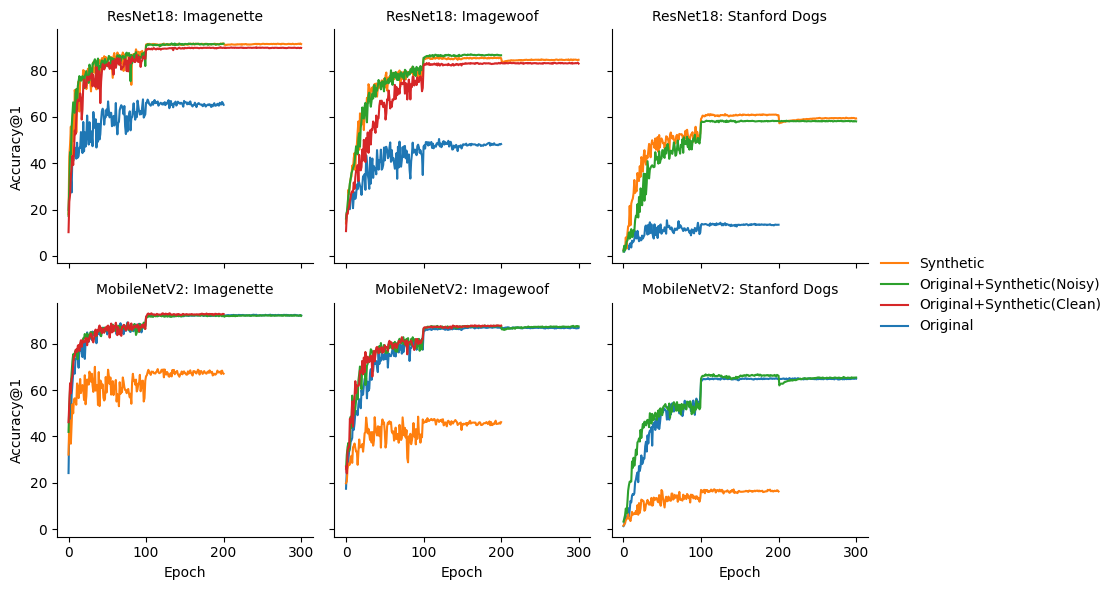

In [10]:
g = sns.FacetGrid(
    df_plot,
    col="type",
    row="model",
)
g.map(sns.lineplot, "epoch", "test_acc1", "data")
g.add_legend()
g.set_titles("{row_name}: {col_name}")
g.set_axis_labels("Epoch", "Accuracy@1")
g.savefig(f'{output_dir}/merged_results.svg')

In [11]:
df_plot.to_csv(f"{output_dir}/table/processed_results.csv", index=False)